In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import sys
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')
import plotly.express as px
warnings.filterwarnings('ignore')
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [ ]:
data = pd.read_excel('Показатели СЭР.xlsx')
data.drop(0, inplace=True)

data = data.convert_dtypes()
data['Полное наименование'] = pd.to_datetime(data['Полное наименование'])
print(data.dtypes)

#переименуем переменные, чтобы с ними было удобнее работать
data.rename(columns={'Полное наименование' : 'Год',
                     'Численность постоянного населения, на начало периода / всего' : 'x1',
                     'Оборот розничной торговли' : 'x2',
                     'Объем платных услуг населению' : 'x3',
                     'Индекс потребительских цен / сводный / к соответствующему месяцу предыдущего года' : 'x4',
                     'Индекс потребительских цен среднегодовой' : 'x5',
                     'Численность рабочей силы (экономически активного населения)' : 'x6',
                     'Численность занятых в экономике' : 'x7',
                     'Денежные доходы на душу населения в месяц' : 'x8',
                     'Среднемесячная заработная плата' : 'x9',
                     'Население, имеющее среднедушевые доходы ниже прожиточного минимума / численность' : 'x10',
                     'Население, имеющее среднедушевые доходы ниже прожиточного минимума / доля' : 'x11',
                     'Децильный коэффициент фондов (соотношение денежных доходов 10% наиболее и 10% наименее обеспеченного населения)' : 'x12',
                     'Коэффициент Джини (индекс концентрации доходов)' : 'x13',
                     'Стоимостная оценка прожиточного минимума в расчете на душу населения' : 'x14',
                     'Валовой региональный продукт в основных ценах' : 'x15',
                     'Индекс физического объема валового регионального продукта в основных ценах' : 'x16',
                     'Валовой региональный продукт на душу населения' : 'x17'}, inplace=True)

'''
Создадим дополнительно 2 новых года для построения прогноза на них.
Объединим с изначальным датафреймом.
'''
new_date = pd.date_range("2023-01-01", periods=2, freq="Y")
new_date = pd.Index(data['Год']) | new_date
df = pd.DataFrame({'Год': new_date})
data = pd.merge(data, df, on='Год', how='right')
#data_test = data.copy()


data.head()

Полное наименование                                                                                                datetime64[ns]
Численность постоянного населения, на начало периода / всего                                                              Float64
Оборот розничной торговли                                                                                                   Int64
Объем платных услуг населению                                                                                             Float64
Индекс потребительских цен / сводный / к соответствующему месяцу предыдущего года                                         Float64
Индекс потребительских цен среднегодовой                                                                                  Float64
Численность рабочей силы (экономически активного населения)                                                               Float64
Численность занятых в экономике                                                           

,Год,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
0,2005-01-01,4686.0,292504,126367.0,112.0,<NA>,2619.5,2562.1,12263.7,<NA>,<NA>,10.3,18.0,0.43,3201.0,666.3928,108.3,141.7956
1,2006-01-01,4713.0,357373,151461.0,110.0,109.64,2725.1,2660.8,13687.0,<NA>,<NA>,10.1,18.5,0.431,3470.0,825.102,108.3,174.4328
2,2007-01-01,4748.0,447928,190066.0,113.2,110.87,2812.1,2754.5,16214.2,16788.3,<NA>,9.6,19.4,0.445,3917.0,1109.297,113.1,235.4103
3,2008-01-01,4765.0,582235,228811.0,114.4,114.91,2808.8,2751.4,16946.0,22075.3,495.9,11.5,17.9,0.434,4660.0,1431.84,109.3,299.436
4,2009-01-01,4799.0,605691,241367.0,108.5,112.73,2847.270451,2730.703238,21552.8,24456.9,419.6,9.4,19.2,0.441,5184.0,1475.8053,94.3,306.4548


In [ ]:
data.tail()

,Год,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
15,2020-01-01,5398.1,1528400,471283.0,104.7,103.21,3097.3,3007.3,48401.0,68667.0,318.5,5.9,14.4,0.4,11704.0,<NA>,<NA>,<NA>
16,2021-01-01,5384.3,1875389,609644.5,108.7,106.6,3101.75,3038.64,56272.0,75958.0,<NA>,<NA>,<NA>,<NA>,11910.4,<NA>,<NA>,<NA>
17,2022-01-01,5378.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13160.2,<NA>,<NA>,<NA>
18,2023-12-31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
19,2024-12-31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
data.isnull().sum()

Год    0
x1     2
x2     3
x3     3
x4     3
x5     4
x6     3
x7     3
x8     3
x9     5
x10    7
x11    4
x12    4
x13    4
x14    2
x15    5
x16    5
x17    5
dtype: int64

In [ ]:
#data.iloc[[-1]] = data.iloc[[-1]].fillna(0) 
#data.iloc[[-2]] = data.iloc[[-2]].fillna(0) 
#data.iloc[[-3]] = data.iloc[[-3]].fillna(0) 

# Предположим, что в будущем ничего не поменяется и все показатели останутся такими же
# Это необходимо, чтобы построить прогноз с помощью регрессии 
data = data.ffill()
data = data.bfill()
data.tail()

,Год,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
15,2020-01-01,5398.1,1528400,471283.0,104.7,103.21,3097.3,3007.3,48401.0,68667.0,318.5,5.9,14.4,0.4,11704.0,5124.6,101.8,950.59
16,2021-01-01,5384.3,1875389,609644.5,108.7,106.6,3101.75,3038.64,56272.0,75958.0,318.5,5.9,14.4,0.4,11910.4,5124.6,101.8,950.59
17,2022-01-01,5378.0,1875389,609644.5,108.7,106.6,3101.75,3038.64,56272.0,75958.0,318.5,5.9,14.4,0.4,13160.2,5124.6,101.8,950.59
18,2023-12-31,5378.0,1875389,609644.5,108.7,106.6,3101.75,3038.64,56272.0,75958.0,318.5,5.9,14.4,0.4,13160.2,5124.6,101.8,950.59
19,2024-12-31,5378.0,1875389,609644.5,108.7,106.6,3101.75,3038.64,56272.0,75958.0,318.5,5.9,14.4,0.4,13160.2,5124.6,101.8,950.59


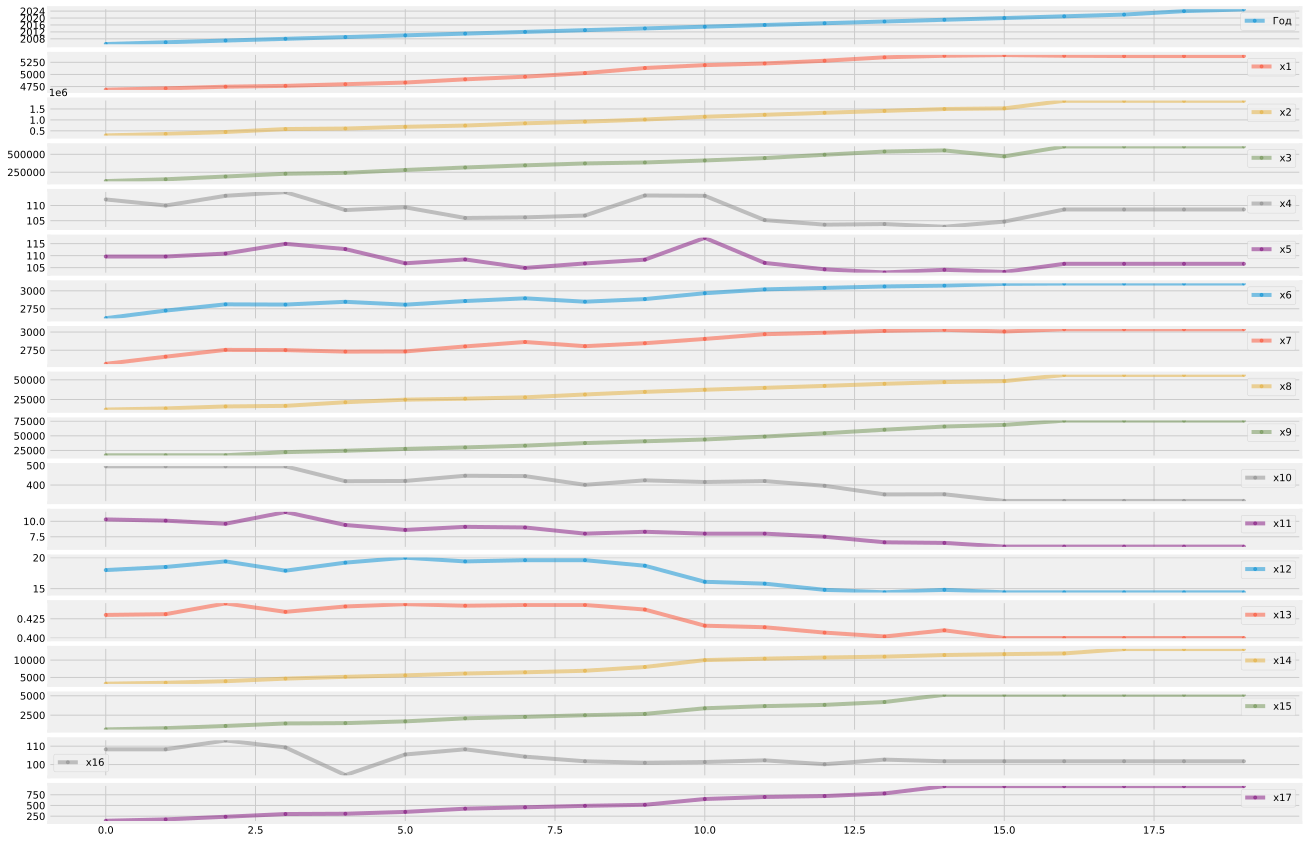

In [ ]:
cols_plot = data.loc[:'2022:01:01'].columns
deepCopiedDF = data.copy(deep=True)
axes = deepCopiedDF[cols_plot].plot(marker='.', alpha=0.5, figsize=(20, 15), subplots=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 17 Text major ticklabel objects>)

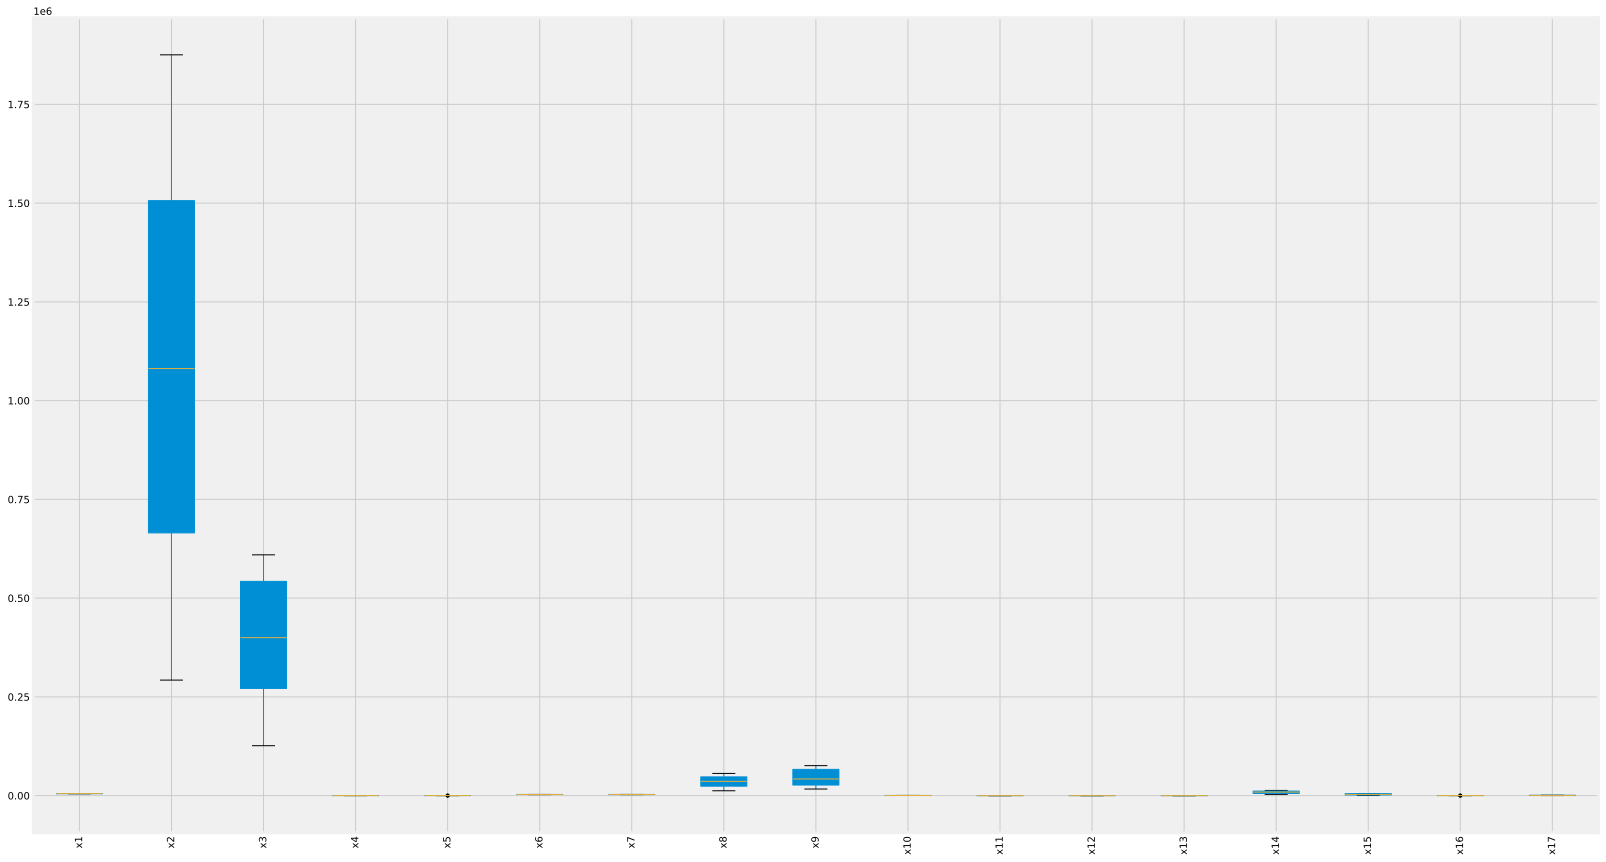

In [ ]:
# обнаружение выбросов
plt.subplots(figsize=(25,15))
data.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [ ]:
data.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17
x1,1.000000,0.963193,0.970450,-0.513565,-0.545488,0.960163,0.966840,0.974609,0.968596,-0.917211,-0.942105,-0.873666,-0.871061,0.984386,0.983583,-0.562025,0.983462
x2,0.963193,1.000000,0.986451,-0.418046,-0.495672,0.956343,0.952763,0.996694,0.993713,-0.948427,-0.943636,-0.862441,-0.872262,0.984029,0.982522,-0.527891,0.982404
x3,0.970450,0.986451,1.000000,-0.487626,-0.532356,0.959527,0.967934,0.989072,0.977140,-0.931966,-0.935858,-0.829970,-0.831606,0.979784,0.974153,-0.547122,0.975757
x4,-0.513565,-0.418046,-0.487626,1.000000,0.789607,-0.523413,-0.530719,-0.450261,-0.462445,0.496650,0.522575,0.383717,0.380075,-0.461678,-0.502684,0.398154,-0.505190
x5,-0.545488,-0.495672,-0.532356,0.789607,1.000000,-0.496902,-0.526000,-0.521425,-0.547356,0.560977,0.618339,0.390651,0.412393,-0.483342,-0.535495,0.202632,-0.531927
x6,0.960163,0.956343,0.959527,-0.523413,-0.496902,1.000000,0.992085,0.957709,0.948450,-0.904347,-0.907207,-0.846488,-0.838485,0.967478,0.968654,-0.543321,0.971308
x7,0.966840,0.952763,0.967934,-0.530719,-0.526000,0.992085,1.000000,0.954787,0.943171,-0.878056,-0.897187,-0.836993,-0.824826,0.965441,0.965634,-0.496546,0.968493
x8,0.974609,0.996694,0.989072,-0.450261,-0.521425,0.957709,0.954787,1.000000,0.992428,-0.956514,-0.960816,-0.849867,-0.861007,0.988188,0.984940,-0.555708,0.985204
x9,0.968596,0.993713,0.977140,-0.462445,-0.547356,0.948450,0.943171,0.992428,1.000000,-0.960232,-0.956304,-0.883832,-0.894355,0.980143,0.989843,-0.522719,0.988095
x10,-0.917211,-0.948427,-0.931966,0.496650,0.560977,-0.904347,-0.878056,-0.956514,-0.960232,1.000000,0.968472,0.783142,0.806580,-0.927391,-0.943953,0.626711,-0.943618


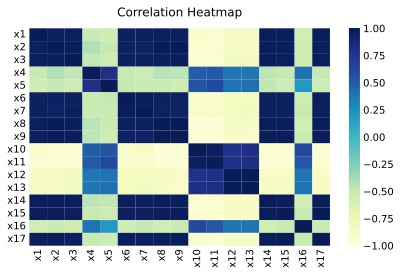

<Figure size 3600x1080 with 0 Axes>

In [ ]:
#mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap="YlGnBu")
plt.figure(figsize=(50,15))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Можно заметить, что между многими факторами наблюдается достаточно большая корреляция, что говорит о линейной зависимости переменных(мультиколлинеарности). Поэтому создадим модель с результирующим признаком, у которого такого не наблюдается. В качестве результирующего признака возьмём x4 - Индекс потребительских цен/сводный/к соответствующему месяцу предыдущего года. Создадим регрессионную переменную ```year_num```. Также, уберем из модели слабо коррелирующие факторы - x12, x13, x16.

Будем строить следующую модель:

$$ y_i = \sum_{i=1}^{k} \beta_i x_i  + \varepsilon_i,$$

где $y_i$ - Индекс потребительских цен/сводный/к соответствующему ммесяцу предыдущего года, результирующий признак, $x_i$ - факторы, включенные в модель, $\varepsilon_i$ - случайный шум.

Факторы, которые включаем в модель:

```year_num``` - порядковый номер года

```x2``` - Оборот розничной торговли

```x3``` - Объем платных услуг населению

```x1``` - Численность постоянного населения, на начало периода / всего 

```x5``` - Индекс потребительских цен среднегодовой

```x6``` - Численность рабочей силы (экономически активного населения)

```x7``` - Численность занятых в экономике

```x8``` - Денежные доходы на душу населения в месяц

```x9``` - Среднемесячная заработная плата

```x10``` - Население, имеющее среднедушевые доходы ниже прожиточного минимума / численность

```x11``` - Население, имеющее среднедушевые доходы ниже прожиточного минимума / доля

```x14``` - Стоимостная оценка прожиточного минимума в расчете на душу населения

```x15``` - Валовой региональный продукт в основных ценах

```x17``` - Валовой региональный продукт на душу населения



In [ ]:
data.index = data['Год']
data.drop(['Год'], axis=1, inplace=True)

In [ ]:
data['year_num'] = range(1, len(data) + 1)
y = data['x4']
X = data[['year_num','x2','x3','x1','x5','x6','x7','x8','x9','x10','x11','x14','x15','x17']]

In [ ]:
# Оставим только те строчки, у которых известны значения y (ранее 2022 года)
X1 = X[X.index < '2022-01-01']
#y1 = data_test['x1'][data_test['x1'].index < 17]
y1 = y[y.index < '2022-01-01']

In [ ]:
# вычислим регрессию со всеми фичами
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X1, y1)
yhat = model.predict(X1)
mae = mean_absolute_error(y1, yhat)
print('MAE: %.3f' % mae)
print("Коэффициент детерминации: %.2f" % metrics.r2_score(y1, yhat))
print(yhat)

MAE: 0.754
Коэффициент детерминации: 0.94
[111.85295134 111.6414838  112.00257628 113.57102843 109.28268549
 107.82459376 105.8804479  107.22888895 107.53603306 112.41404251
 113.3818548  106.59613635 102.43261311 104.04198    102.81329907
 104.40248402 108.99690113]


```MAE``` -  средняя абсолютная ошибка, этот показатель говорит нам о том, насколько точны наши прогнозы и какова величина отклонений. В целом, в нашей модели нет сильных отклонений.

```Коэффициент детерминации``` - количественный показатель того, насколько хороша наша модель. В нашем случае можно интерпретировать как 94% предсказаний модели верны.

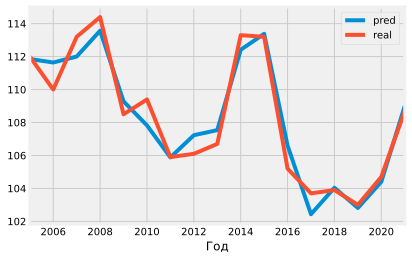

In [ ]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные 2022-2024 годы.

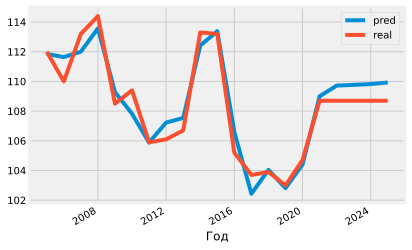

In [ ]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [ ]:
pred

,pred,real
Год,,
2005-01-01,111.852951,112.0
2006-01-01,111.641484,110.0
2007-01-01,112.002576,113.2
2008-01-01,113.571028,114.4
2009-01-01,109.282685,108.5
2010-01-01,107.824594,109.4
2011-01-01,105.880448,105.9
2012-01-01,107.228889,106.1
2013-01-01,107.536033,106.7
